# Practical 2
## A Graph Neural Network Model for Node Classification
### (and how to build it from scratch)

### Overview
In this practical, you will implement the base graph neural network model from scratch (without using PyTorch Geometric), and prepare it for node classification. You will train your model for node classification on Cora dataset, which is an academic citation network. The task is to predict the category of each paper (which corresponds to a node in the citation network) among the seven available. We introduced the base graph neural network model in the course, as an instance of message passing neural networks, and studied a particular parameterization of this model.

For each part and task, answer the given questions and complete the code where missing (this is indicated by the `pass` keyword).

## Part 0: Installing dependencies
Despite the fact we will not use PyTorch Geometric to build the GNN, we will use it to handle the Cora dataset, as it is included in the base distribution.
Follow the given instructions to set up your Colab notebook correctly.

First of all, we advice you to enable GPU acceleration for your notebook. This can be done by navigating to `Runtime > Change runtime type > Hardware accelerator (GPU) > Save`. You may getting an error explaining that no GPUs are currently available. This is fine, you don't really need them for this practical, however they'll make your computations significantly faster.

Some other tips & tricks:
- press `Shift + Enter` to run a cell and move to the next one (`Ctrl + Enter` to only run it)
- when you execute a cell, the variables you create are saved into a global namespace. As a consequence, changes in the code will not take effect until you re-run that specific cell.
- remember to save your notebook every once in a while!

In [1]:
# Check PyTorch version installed on this system
!python -c "import torch; print(torch.__version__)"

2.4.0


In [2]:
%%capture
# Download the corresponding PyTorch Geometric module
"""
Assign to TORCH with what you get from the cell above. E.g., export TORCH=1.12.1+cu113
# """
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-2.4.0.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-2.4.0.html
# !pip install torch-geometric

## Part 1: Building a GNN
In this part, you will build a GNN using PyTorch, aiming to emulate the PyTorch Geometric modules. You will construct your neural network using PyTorch nn modules, and build training and testing helper functions to train and evaluate your model.

### Task 1.1
Understand the base structure of a PyTorch neural network model, namely `torch.nn.Module`, and build your GNN as a class with its own instantiation of `__init__` and `forward`. You will define GNN components within `__init__`, and construct the GNN data flow in `forward`. We recommend that you construct your model such that the number of layers is parametrized. That is, you can increase or decrease the number of layers simply by changing the range of an inner loop that creates the needed layers.

Furthermore, as a node classification GNN is composed by a sequence of Graph Convolution Layers and by a Multi Layer Perceptron head used to classify each node, we suggest to define a separate module for each of these components, and then aggregate them together in the final model.

In [3]:
# Let's first import all the things we are gonna need for this task
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
# torch_geometric only used to load the Cora dataset
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
import torch_geometric.utils as U
    
device = torch.device("mps")

dataset = Planetoid("/tmp/Cora", name="Cora")
num_nodes = dataset.data.num_nodes
num_edges = dataset.data.num_edges // 2
num_features = dataset.num_node_features
num_classes = dataset.num_classes

/Users/fairyliu/anaconda3/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [4]:
print(num_nodes)
print(num_edges)
print(num_features)
print(num_classes)

2708
5278
1433
7


Please complete the following classes, adding the respective `__init__` and `forward` methods.  
Please construct your model such that the number of layers is parametrized. That is, you can increase or decrease the number of layers simply by changing the range of an inner loop that creates the needed layers. In general, try to hard-code the least amount of behaviour inside your network. Prefer, instead, the use of parameters passed during initialization, as it will come in handy later on (e.g., you can chosse to hard code the activation functions used for each model but also leave them as a model parameter).

A `GNNLayer` computes the operations seen in the lectures, that is:

$ h_i^{(t+1)} = \sigma(W^{(t)}_{self} h_i^{(t)} + W^{(t)}_{neigh} \sum_{j \in neigh(i)} h_j^{(t)})$.

Remember that PyTorch is realy efficient in parallelizing computations by vectorizing them. In other words, you don't need to (you must not!) loop over all the neighbours of each node to compute the summation in the above equation. Use instead matrix operations.

In [5]:
class GNNLayer(nn.Module):

    # create one single layer
    # H Wself + A H Wneigh.  H: n*input, Wself: input*output
    # _init_ specifies parameters in one layer (the knowledge passing function is one layer's operation)

    def __init__(self, input_dim, output_dim, activation=nn.ReLU()):
        super(GNNLayer, self).__init__()
        
        # Define self and neighbor transformation matrices
        self.W_self = nn.Linear(input_dim, output_dim)  # W_self matrix
        self.W_neigh = nn.Linear(input_dim, output_dim) # W_neigh matrix
        self.activation = activation 
    
    def forward(self, node_feats, adj_matrix):
        # Apply the self-node transformation
        self_feats = self.W_self(node_feats)  # Shape: (num_nodes, output_dim)
        
        # Aggregate neighbor features
        neigh_feats = torch.matmul(adj_matrix, node_feats)  # Shape: (num_nodes, input_dim)
        neigh_feats = self.W_neigh(neigh_feats)  
        
        # Sum self and neighbor features, then apply activation
        out = self_feats + neigh_feats
        out = self.activation(out)
        
        return out

The `GNNModule` is a collection of GNNLayers. In PyTorch you can create a list of layers by using `nn.ModuleList(layer_1, layer_2, ...)` or, equivalentely `nn.ModuleList(*layer_list)`. Remember activation functions!

In [6]:
class GNNModule(nn.Module):
 
    # loop through multiple layers
    # input layer: input->hidden, (hidden->hidden), hidden->output
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=nn.ReLU()):
        super(GNNModule, self).__init__()
        layer_list = []
        layer_in = GNNLayer(input_dim, hidden_dim, act_fn)
        layer_list.append(layer_in)
        
        for i in range(num_layers - 2):
            layer = GNNLayer(hidden_dim, hidden_dim, act_fn)
            layer_list.append(layer)
        
        layer_out = GNNLayer(hidden_dim, output_dim, act_fn)
        layer_list.append(layer_out)
        
        self.layers = nn.ModuleList(layer_list)

    def forward(self, x, adj_matrix):
        for layer in self.layers:
            x = layer(x, adj_matrix)
        
        return x
        

The `MLPModule` is a classification head that you apply to each node in the input graph after applying the gnn layers. It is a collection of `nn.Linear` layers.

In [7]:
class MLPModule(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=nn.ReLU()):
        super(MLPModule, self).__init__()
        
        layer_list = []
        layer_list.append(nn.Linear(input_dim, hidden_dim))
        layer_list.append(act_fn)
        
        for i in range(num_layers - 2):
            layer_list.append(nn.Linear(hidden_dim, hidden_dim))
            layer_list.append(act_fn)
        
        # Output layer (without activation)
        layer_list.append(nn.Linear(hidden_dim, output_dim))
        
        self.layers = nn.Sequential(*layer_list)

    def forward(self, x):        
        out = self.layers(x)
 
        return out
        

Let's aggregate everything in a single class:

In [8]:
class CoraNodeClassification(nn.Module):
    
    def __init__(self, gnn_input_dim, gnn_hidden_dim, gnn_output_dim, mlp_hidden_dim, mlp_output_dim, gnn_num_layers=2, mlp_num_layers=2, gnn_act_fn = nn.ReLU(), mlp_act_fn = nn.ReLU()):
        super(CoraNodeClassification, self).__init__()
        self.gnnModule = GNNModule(gnn_input_dim, gnn_hidden_dim, gnn_output_dim, gnn_num_layers, gnn_act_fn)
        self.mlpModule = MLPModule(gnn_output_dim, mlp_hidden_dim, mlp_output_dim, mlp_num_layers, mlp_act_fn)

    def forward(self, x, adj_matrix):
        y = self.gnnModule(x, adj_matrix)
        out = self.mlpModule(y)
        
        return out
        
    # Used to reset the weights of the network when training multiple times with
    # different hyperparameters
    def reset_parameters(self):
        def _reset_module_parameters(module):
            for layer in module.children():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
                elif hasattr(layer, 'children'):
                    for child_layer in layer.children():
                        _reset_module_parameters(child_layer)

        _reset_module_parameters(self)

### Task 1.2
Create dedicated functions for training and testing. For training, your functions should return a vector containing the train loss and accuracy after each epoch (since Cora contains a single graph one epoch corresponds to one training iteration). You can also print out those values while the training it's running. However, given the large number of epochs, we advise you print every 8 steps or so. Your test function should return the final accuracy on the test set. If everything works correctly you should get around ~75% accuracy.

Cora uses a masking approach to divide between the train and test set. Therefore, to compute the loss/accuracy, mask out the part of your output based on the current settings, e.g., `loss = model.loss_fn(y[data.train_mask], data.y[data.train_mask])`

In [9]:
# The Cora dataset contains a single graph of 2708 nodes (i.e., papers).
# We will use some of the nodes as training set and some as test set.
data = dataset[0].to(device)

# According to the GNN equations, we need the adjacency matrix to compute each
# layer convolution. The following line convert the sparse data
# (i.e., list of edges) stored in the dataset in a single dense matrix.
adj_matrix = U.to_dense_adj(data.edge_index).squeeze(0)

# Define the hyperparameters we are gonna use:
params = {
    "hidden_features": 128,
    "gnn_output_dim": 64,
    "mlp_hidden_dim": 32,
    "num_gcn_layers": 2,
    "num_mlp_layers": 2,
    "learning_rate": 1e-4,
    "weight_decay": 0,
    "num_epochs": 300,
}

# Remember to move the model to the correct device using `.to(device)`
# The arguments to be passed to the class CoraNodeClassification __init__ functions
# depends on how you defined the method. This is an example.
model = CoraNodeClassification(num_features,
                               params["hidden_features"],
                               params["gnn_output_dim"],
                               params["mlp_hidden_dim"],
                               num_classes,
                               params["num_gcn_layers"],
                               params["num_mlp_layers"],
                               gnn_act_fn=nn.ReLU(),  
                               mlp_act_fn=nn.ReLU()
  ).to(device)

In [10]:
def test(model, data, adj_matrix, params):
    model.eval() 
    
    # Forward pass
    with torch.no_grad():
        out = model(data.x, adj_matrix)

    _, pred = out[data.test_mask].max(dim=1)
    test_accuracy = 100* (pred == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()

    return test_accuracy


# By testing a random initialized module you should get around ~15% accuracy
test(model, data, adj_matrix, params)

15.3

In [11]:
# def train(model, data, adj_matrix, params):
#     optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
#     num_epochs = params["num_epochs"]

#     # Lists to store loss and accuracy for each epoch
#     losses = []
#     accuracies = []

#     for epoch in range(num_epochs):
#         model.train()

#         # Forward pass
#         out = model(data.x, adj_matrix)

#         # Calculate loss (using only the training mask)
#         train_loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])

#         # Backward pass
#         optimizer.zero_grad()
#         train_loss.backward()
#         optimizer.step()

#         # Calculate accuracy (using only the training mask)
#         _, pred = out[data.train_mask].max(dim=1)
#         train_acc = (pred == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()

#         losses.append(train_loss.item())
#         accuracies.append(train_acc)

#         # Print every 8 steps
#         if (epoch + 1) % 8 == 0:
#             print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss.item():.4f}, Accuracy: {train_acc:.4f}")

#     return losses, accuracies

# train_losses, train_accuracies = train(model, data, adj_matrix, params)
# # Now you shold get around ~75-77%!
# test_accuracy = test(model, data, adj_matrix, params)
# print("Final test accuracy:", test_accuracy)

In [12]:
def train(model, data, adj_matrix, params):
    optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
    num_epochs = params["num_epochs"]

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()  
        out = model(data.x, adj_matrix)
        train_loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        _, train_pred = out[data.train_mask].max(dim=1)
        train_acc = (train_pred == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()

        model.eval()  
        with torch.no_grad():
            test_out = model(data.x, adj_matrix)
            _, test_pred = test_out[data.test_mask].max(dim=1)
            test_acc = (test_pred == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()

        train_losses.append(train_loss.item())
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)   

        # Print every 8 steps
        if (epoch + 1) % 8 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

    return train_losses, train_accuracies, test_accuracies


#### Task 1.2.1
Can you modify the training function to return the test accuracy at every step as well?
By plotting the train accuracy and test accuracy over time, what can you observe?


From the result, we can observe that: with the number of epoches increasing, the training and testing accuracy increase. (While training accracy increases faster than testing accuracy, with its gradient larger) But at some point, the both accuracies reach the platform, which cannot be improved over time. And testing accuracy reach the peak faster than training accuracy.

Epoch 8/300, Loss: 1.8243, Train Accuracy: 0.2929, Test Accuracy: 0.1880
Epoch 16/300, Loss: 1.7201, Train Accuracy: 0.3714, Test Accuracy: 0.2610
Epoch 24/300, Loss: 1.6141, Train Accuracy: 0.5286, Test Accuracy: 0.3300
Epoch 32/300, Loss: 1.5103, Train Accuracy: 0.6857, Test Accuracy: 0.4080
Epoch 40/300, Loss: 1.4067, Train Accuracy: 0.7357, Test Accuracy: 0.4690
Epoch 48/300, Loss: 1.2990, Train Accuracy: 0.8071, Test Accuracy: 0.5420
Epoch 56/300, Loss: 1.1874, Train Accuracy: 0.8571, Test Accuracy: 0.5900
Epoch 64/300, Loss: 1.0754, Train Accuracy: 0.8857, Test Accuracy: 0.6260
Epoch 72/300, Loss: 0.9663, Train Accuracy: 0.9357, Test Accuracy: 0.6620
Epoch 80/300, Loss: 0.8641, Train Accuracy: 0.9429, Test Accuracy: 0.6930
Epoch 88/300, Loss: 0.7695, Train Accuracy: 0.9571, Test Accuracy: 0.7050
Epoch 96/300, Loss: 0.6815, Train Accuracy: 0.9786, Test Accuracy: 0.7100
Epoch 104/300, Loss: 0.6027, Train Accuracy: 0.9857, Test Accuracy: 0.7120
Epoch 112/300, Loss: 0.5318, Train Acc

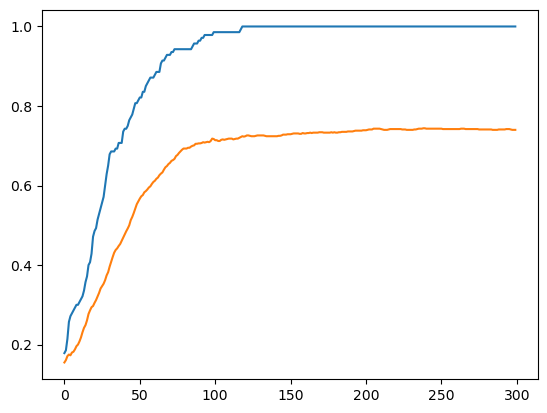

Final test accuracy: 0.74


In [13]:
train_losses, train_accuracies, test_accuracies= train(model, data, adj_matrix, params)

import matplotlib.pyplot as plt

plt.plot(train_accuracies)
plt.plot(test_accuracies)
plt.show()

print("Final test accuracy:", test_accuracies[-1])

## Part 2: Ablation Studies (Optional)

### 2.1: Importance of GNN and MLP modules
Add a parameter to the `CoraNodeClassification` class that allows you to select which modules to enable: only GNN, only MLP, or both. For example, your `forward` should look similarly to the following:

```python
def forward(self, x, adj_matrix):
    if self.gnn is not None:
      x = self.gnn(x, adj_matrix)
    
    if self.mlp is not None:
      x = self.mlp(x)

    return x
```

What is the impact of the two modules on the final result? Play a little around `hidden_features` and `num_layers` and briefly describe what you observe.

observe: 

    params = {
    "hidden_features": 128,
    "gnn_output_dim": 7,
    "mlp_hidden_dim": 7,
    "num_gcn_layers": 5,
    "num_mlp_layers": 2,
    "learning_rate": 1e-4,
    "weight_decay": 0,
    "num_epochs": 2000, }
    
 final test accuracy: 0.637, accuracy first increase, but at some point it reaches platform, and after a while accuracy increase and reaches to another platform (and stay around 0.63 permanently)
 
 
observe:

    params = {
    "hidden_features": 128,
    "gnn_output_dim": 7,
    "mlp_hidden_dim": 7,
    "num_gcn_layers": 3,
    "num_mlp_layers": 2,
    "learning_rate": 1e-4,
    "weight_decay": 0,
    "num_epochs": 2000,}
    
 final test accuracy: 0.633, test accruacy first increases, then at around 250 epoches reaches its platform.
 But training accuracy have "steps".  (Why?)
 
 
 
 when setting num_gnn_layers = 2, num_mlp_layers = 10 -> test accuracies 0.38
 adding mlp-layers, make generalization power/accuracies drop greatly.
 
 when setting num_gnn_layers = 10, num_mlp_layers = 2 -> test accuracy: 0.143
 results even worse than previously.
 
 
 
 changing the output dimension of gnn layers -> better result
 
 
     params = {
    "hidden_features": 128,
    "gnn_output_dim": 64,
    "mlp_hidden_dim": 32,
    "num_gcn_layers": 5,
    "num_mlp_layers": 2,
    "learning_rate": 1e-4,
    "weight_decay": 0,
    "num_epochs": 500,}
    
Train Accuracy: 0.9714, Test Accuracy: 0.6770

    params = {
    "hidden_features": 128,
    "gnn_output_dim": 64,
    "mlp_hidden_dim": 32,
    "num_gcn_layers": 3,
    "num_mlp_layers": 2,
    "learning_rate": 1e-4,
    "weight_decay": 0,
    "num_epochs": 500,}

Epoch 496/500, Loss: 0.0034, Train Accuracy: 1.0000, Test Accuracy: 0.7300
 
 
    params = {
    "hidden_features": 128,
    "gnn_output_dim": 64,
    "mlp_hidden_dim": 32,
    "num_gcn_layers": 2,
    "num_mlp_layers": 2,
    "learning_rate": 1e-4,
    "weight_decay": 0,
    "num_epochs": 500,}
    
 Epoch 496/500, Loss: 0.0088, Train Accuracy: 1.0000, Test Accuracy: 0.7310
 
 


observe that without GNN module or MLP module, the training and testing accuracies drop significantly.

### 2.2: Importance of non-linearities
Try to replace all your activation functions with identities (or simply remove them). Do the results change? What does this tell you about this specific problem?

### After replacing all acitivation functions with identities, the results indeed change:
    Epoch 296/300, Loss: 0.0198, Train Accuracy: 1.0000, Test Accuracy: 0.7290
    With same parameters, the test accuracy drop slightly. So we can conclude that the non-linearities (relu/sig) is important in training
    
    (doesn't change much? Why?)